# The point of this jupyter notebook is to test the implementation of the library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from src import *
from dataset.data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

### Test of the affine layer

In [2]:
# Test the affine forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

aff = Affine_layer(output_dim)
aff.weights = w
aff.biases = b

out = aff.forward(x)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('Difference: ' + str(rel_error(out, correct_out)))

Testing affine_forward function:
Difference: 9.769849468192957e-10


In [3]:
# Test the affine backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

aff.weights = w
aff.biases = b

dx_num = eval_numerical_gradient_array(lambda x: aff.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda _: aff.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda _: aff.forward(x), b, dout)

dx, dw, db = aff.backward(dout)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ' + str(rel_error(dx_num, dx)))
print('dw error: ' + str(rel_error(dw_num, dw)))
print('db error: ' + str(rel_error(db_num, db)))

Testing affine_backward function:
dx error: 5.399100368651805e-11
dw error: 9.904211865398145e-11
db error: 2.4122867568119087e-11


### Test of the relu layer

In [4]:
# Test the relu forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

rel = Relu_layer()

out = rel.forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ' + str(rel_error(out, correct_out)))

Testing relu_forward function:
difference: 4.999999798022158e-08


In [5]:
# Test the relu backward function

np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: rel.forward(x), x, dout)

dx = rel.backward(dout)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ' + str(rel_error(dx_num, dx)))

Testing relu_backward function:
dx error: 3.2756349136310288e-12


### Test the losses implementations

In [6]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

#SVM
loss = Loss_computer('svm')

dx_num = eval_numerical_gradient(lambda x: loss.compute_loss(x, y)[0], x, verbose=False)
loss, dx = loss.compute_loss(x, y)

# Test svm loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

#SOFTMAX
loss = Loss_computer('softmax')

dx_num = eval_numerical_gradient(lambda x: loss.compute_loss(x, y)[0], x, verbose=False)
loss, dx = loss.compute_loss(x, y)

# Test softmax loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
('loss: ', 8.999602749096233)
('dx error: ', 1.4021566006651672e-09)

Testing softmax_loss:
('loss: ', 2.302545844500738)
('dx error: ', 9.384673161989355e-09)


### Test a two layers net

In [7]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
hidden_layers = [
    Affine_layer(H),
    Relu_layer()
]

initialiser = Initialiser(config = {'method': 'normal', 'std_dev': std})
model = Net(D, C, hidden_layers=hidden_layers, initialiser=initialiser)

print('Testing initialization ... ')
W1_std = abs(model.hidden_layers[0].weights.std() - std)
b1 = model.hidden_layers[0].biases
W2_std = abs(model.hidden_layers[2].weights.std() - std)
b2 = model.hidden_layers[2].biases
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.hidden_layers[0].weights = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.hidden_layers[0].biases = np.linspace(-0.1, 0.9, num=H)
model.hidden_layers[2].weights = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.hidden_layers[2].biases = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

print('Testing training loss (regularization)')
model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ' + str(reg))
  model.reg = reg
  loss, grads = model.loss(X, y)
  for i in range(len(grads)):
    for name in grads[i]:
      f = lambda _: model.loss(X, y)[0]
      grad_num = None
      if i == 0:
        if name == 'b':
          grad_num = eval_numerical_gradient(f, model.hidden_layers[i].biases, verbose=False)
        else:
          grad_num = eval_numerical_gradient(f, model.hidden_layers[i].weights, verbose=False)
      else:
        if name == 'b':
          grad_num = eval_numerical_gradient(f, model.hidden_layers[i + 1].biases, verbose=False)
        else:
          grad_num = eval_numerical_gradient(f, model.hidden_layers[i + 1].weights, verbose=False)
      print('%s relative error: %.2e' % (name + str(i + 1), rel_error(grad_num, grads[i][name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Testing training loss (regularization)
Running numeric gradient check with reg = 0.0
b1 relative error: 9.83e-09
w1 relative error: 1.83e-08
b2 relative error: 4.33e-10
w2 relative error: 3.12e-10
Running numeric gradient check with reg = 0.7
b1 relative error: 1.35e-08
w1 relative error: 3.12e-07
b2 relative error: 1.97e-09
w2 relative error: 7.98e-08


### Test the solver implementation

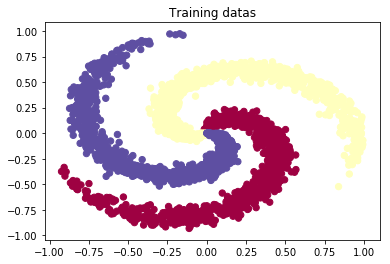

In [8]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.title('Training datas')
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

X_train = X
y_train = y

N = 50
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

X_val = X
y_val = y

N = 10000
X = np.zeros((N,D)) # data matrix (each row = single example)

index = 0
for i in range(100):
    for j in range(100):
        _i = (float(i - 50) / 50.0)
        _j = (float(j - 50) / 50.0)
        X[index] = [_i, _j]
        index += 1

X_test = X

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test
}

0.9666666666666667


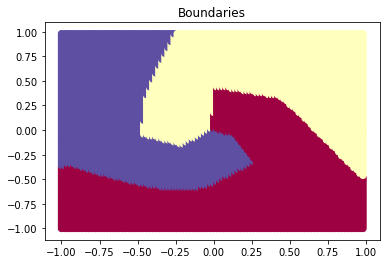

In [87]:
hidden_layers = [
    Affine_layer(140),
    Relu_layer(),
]
std = 1e-3
initialiser = Initialiser(config = {'method': 'normal', 'std_dev': std})

input_size = 2
output_size = 3
reg = 1e-3
model = Net(input_size, output_size, hidden_layers=hidden_layers, initialiser=initialiser, reg=reg)

lr = 1.5
optims = [
    [Sgd(lr), Sgd(lr)],
    [Sgd(lr), Sgd(lr)]
]
solver = Solver(model, data, optims=optims, lr_decay=0.99, batch_size=130, print_every=300, num_epochs=80, verbose=False)
solver.train()
print(solver.check_accuracy(data['X_val'], data['y_val']))
predictions = solver.predict(data['X_test'])
plt.title('Boundaries')
plt.scatter(data['X_test'][:, 0], data['X_test'][:, 1], c=predictions, s=40, cmap=plt.cm.Spectral)
plt.show()

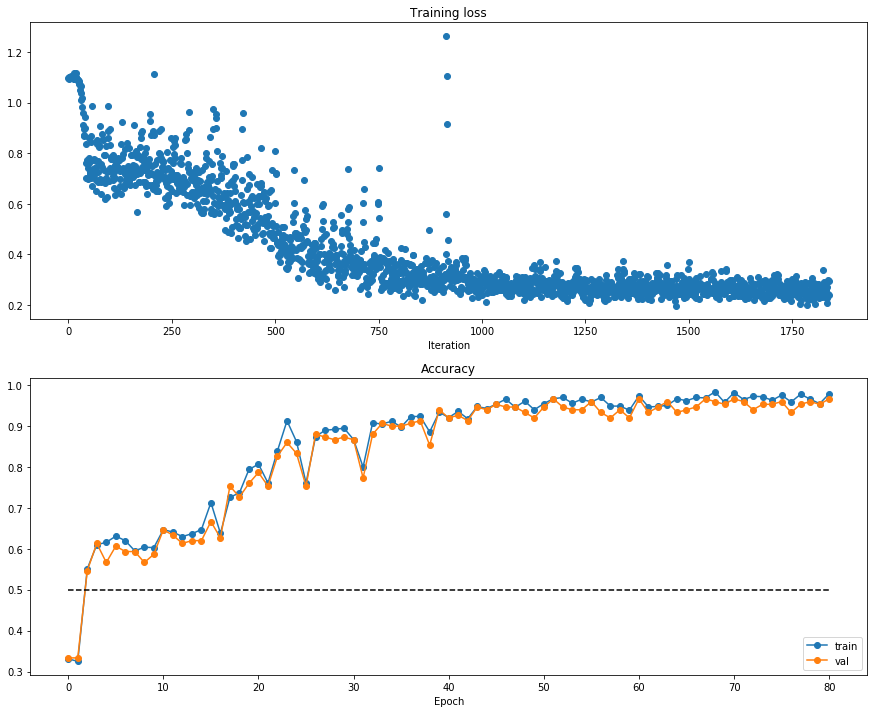

In [88]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()